## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

In [1]:
! git clone https://www.github.com/vrhughes/PCA

Cloning into 'PCA'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 69 (delta 16), reused 13 (delta 7), pack-reused 39 (from 1)
Receiving objects: 100% (69/69), 2.82 MiB | 9.34 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
# Import all the stuff :)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import pickle
from collections import Counter
from multiprocessing.pool import Pool

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [ ]:
# Question 1
# now reading in the parquet data
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
print(df)

       index  Unnamed: 0                                         Email Text  \
0          0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1          1           1  the other side of * galicismos * * galicismo *...   
2          2           2  re : equistar deal tickets are you still avail...   
3          3           3  \nHello I am your hot lil horny toy.\n    I am...   
4          4           4  software at incredibly low prices ( 86 % lower...   
...      ...         ...                                                ...   
18629  18645       18646  date a lonely housewife always wanted to date ...   
18630  18646       18647  request submitted : access request for anita ....   
18631  18647       18648  re : important - prc mtg hi dorn & john , as y...   
18632  18648       18649  press clippings - letter on californian utilit...   
18633  18649       18650                                              empty   

           Email Type  
0          Safe Email  
1  

In [ ]:
# Question 1
# spliting the email values into tokens
tokens = df['Email Text'].str.split()

tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


In [ ]:
# Question 1
# cleaning the data
import string

# remove punctuation from the tokens
for email in tokens:
   for i in range(len(email)):
      email[i] = email[i].translate(str.maketrans('', '', string.punctuation))

tokens.head()


,Email Text
0,"[re, , 6, , 1100, , disc, , uniformitarianism,..."
1,"[the, other, side, of, , galicismos, , , galic..."
2,"[re, , equistar, deal, tickets, are, you, stil..."
3,"[Hello, I, am, your, hot, lil, horny, toy, I, ..."
4,"[software, at, incredibly, low, prices, , 86, ..."


Question 1:

> In order to clean the tokens I would remove punctuation (as seen above) and then I would clear those empty spaced in the tokens series. After that I would probably try and make a list of buzz words like "deal", "prices", "click", "hot", etc that commonly occur in phishing emails and see if they appear in an email. If only one word occurs, that could just be a coincidence (business email addressing prices), but if multiple buzzwords show up in an email I would then sort those into another category called potential phishing or something along those lines.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [ ]:
with open('/content/PCA/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: >

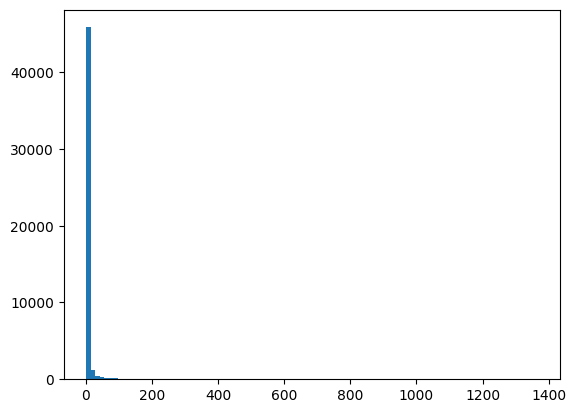

In [ ]:
token_occurences = pd.DataFrame(token_freq,columns=['token','count'])
token_occurences['count'].hist(grid=False,bins=100)

> The large majority of tokens do not occur frequently (most occur once, only a few even occur twice), however there is a token that is clearly incredibly common (which is messing up my y axis).

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [4]:
# Question 3
clean = pd.read_parquet('/content/PCA/05_PCA/Phishing_clean.parquet')

y = clean['Email Type']
X = clean.drop('Email Type', axis=1)

In [6]:
# Question 3
# train-test split and linear regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

model = LinearRegression()
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

r_squared_train = model.score(X_train, y_train)
r_squared_test = model.score(X_test, y_test)

lm_0 = LinearRegression(fit_intercept=False).fit(X_train ,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('Train: ', r2_score(y_hat_train, y_train) )
print('Test: ', r2_score(y_hat_test, y_test) )

Train:  0.6943020316384483
Test:  -0.00026838432581777205


In [7]:
# Question 3
# what words have largest coeffs in absolute value and most strongly influence predictions?

large = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
large['abs'] = np.abs(large['value']) # making space
large.sort_values('abs',ascending=False) # sorting

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


> As it turns out the variables with the largest coefficients are numbers, not any words made up of alphabetical characters.

> The training set data looks good with an R^2 value of 0.62, but the test data looks atrocious! We can come to the conclusion that the model is over-fitting. :(

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

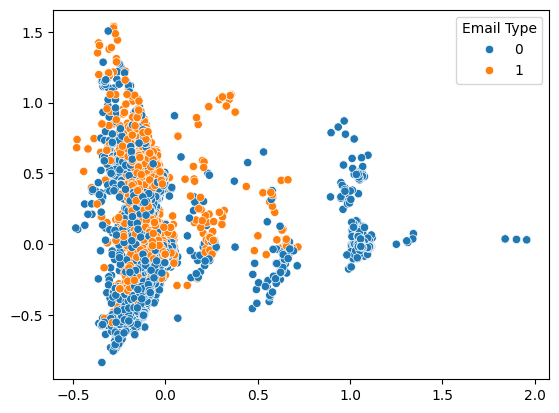

In [8]:
# Question 4

# making the decomposition
decomp = PCA(n_components=2).fit(X_train)
Z_train = decomp.transform(X_train)
Z_test = decomp.transform(X_test)

# plotting shenanigans
sns.scatterplot(x = Z_train[:, 0], y = Z_train[:, 1], hue = y_train)


> Wow! Looks like the fish Gil from Finding Nemo, but with different colors.

> Orange dots are scams and they on average have a lower first component and a higher second component. Meanwhile, the blue are normal emails.



### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [9]:
# Question 5

# parte dos
decomp2 = PCA(n_components = 2610).fit(X_train)
Z_train2 = decomp2.transform(X_train)
Z_test2 = decomp2.transform(X_test)

# lin reg time
lm_2 = LinearRegression().fit(Z_train2 ,y_train)
y_hat_test2 = lm_2.predict(Z_test2)
y_hat_train2 = lm_2.predict(Z_train2)

# let's print some stuff
print('Training R^2: ', r2_score(y_hat_train2, y_train))
print('Testing R^2: ', r2_score(y_hat_test2, y_test))

Training R^2:  0.692897536096375
Testing R^2:  0.5873905973217184


> YAY! This looks much better (especially on the test set) compared to the original linear regression where the R^2 was basically 0 for the test set. Additionally, the R^2 for the test set is now much more closely aligned with the R^2 of the training set which is good to see. :)

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data. The drawbacks?

> The advantage of using principle component is that the elements of the prediction matrix are made orthogonal (perpendicular) which means that our nemesis multi-collinearity does not happen. With this, the model can do a much better job at fitting the data. Plus, it is much less components to deal with (1-2711 vs 2^2711) which is always appreciated.

> On the other hand, we cannot interpret what the components are. :(